# Face Tracer

Create visualizations based on the FaceTracer dataset

In [46]:
%reload_ext autoreload
%autoreload 2

import os
from os.path import join
from pathlib import Path
import math

import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.utils import im_utils, file_utils

In [3]:
dir_facetracer = join(cfg.DATA_STORE_NAS, 'datasets/people/face_tracer')

In [5]:
%ls $dir_facetracer

attributes.txt                                @eaDir/         facetracer.zip
Bitouk_SIGGRAPH08.pdf                         faceindex.txt   Kumar_ECCV08.pdf
CAVE _ Databases_ FaceTracer Database_files/  facelabels.txt  url.txt
CAVE _ Databases_ FaceTracer Database.html    facestats.txt
CAVE _ Databases_ FaceTracer Database.pdf     facetracer.py


In [10]:
%cat $dir_facetracer/'facestats.txt' | head -n5

# FaceTracer Dataset v1.0 - facestats.txt - http://www.cs.columbia.edu/CAVE/databases/facetracer/
# Format: face_id	crop_w	crop_h	crop_x0	crop_y0	yaw	pitch	roll	left_eye_left_x	left_eye_left_y	left_eye_right_x	left_eye_right_y	right_eye_left_x	right_eye_left_y	right_eye_right_x	right_eye_right_y	mouth_left_x	mouth_left_y	mouth_right_x	mouth_right_y
1	133	138	0	0	-6	3	5	35	69	50	71	71	73	87	72	41	104	79	106
2	64	72	71	0	-14	17	-8	21	24	26	23	35	21	41	19	27	39	42	35
3	128	180	0	0	-9	6	4	32	76	46	77	65	79	80	78	37	108	72	110
cat: write error: Broken pipe


In [20]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers:

read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=None, error_bad_lines=True, warn_bad_lines=True, skipfooter=0, doublequote=True, delim_whitespace=False, low_memory=True, memory_map=False, float_precision=None)
    Read CSV (comma-separated) file into DataFrame
    
    Also supports optionally itera

In [124]:
fp_stats = join(dir_facetracer, 'facestats.csv')

In [135]:
class FaceData:
  
  def __init__(self, d):
    # convert defaulta data to normalized square
    self.dots = []
    x, y = d['crop_x0'], d['crop_y0']
    w, h = d['crop_w'], d['crop_h']
    # left eye, left
    self.dots.append( [d['left_eye_left_x'], d['left_eye_left_y']] )
    # left eye, right
    self.dots.append( [d['left_eye_right_x'], d['left_eye_right_y']] )
    # right eye, left
    self.dots.append( [d['right_eye_left_x'], d['right_eye_left_y']] )
    # right eye, right
    self.dots.append( [d['right_eye_right_x'], d['right_eye_right_y']] ) 
    # mouth left
    self.dots.append( [d['mouth_left_x'], d['mouth_left_y']] )
    # mouth right
    self.dots.append( [d['mouth_right_x'], d['mouth_right_y']] )
    
    # normalize points
    self.dots_norm = self.dots.copy()
    for dot in self.dots_norm:
      dot[0] /= w
      dot[1] /= h
      
      
  def to_dim(self, wh):
    scaled  = []
    for d in self.dots:
      scaled.append( (int(d[0] * wh[0]), int(d[1] * wh[1])) )
    return scaled

In [143]:
df_stats = pd.read_csv(fp_stats, delimiter='\t')
#df_stats = df_stats[0:20]

faces = []
for i, row in df_stats.iterrows():
  faces.append(FaceData(row))

In [144]:
import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.pyplot as plt
from matplotlib import cm

def get_color_map(cmap='prism', ncolors=20, as_hex=False, reverse=False, bgr=True):
  norm  = mpl.colors.Normalize(vmin=0, vmax=ncolors-1)
  scalars = mplcm.ScalarMappable(norm=norm, cmap=cmap)
  colors = [scalars.to_rgba(i) for i in range(ncolors)]
  colors = [(int(255*c[0]),int(255*c[1]),int(255*c[2])) for c in colors]  
  if reverse:
    colors = colors[::-1]
  if bgr:
    colors = [c[::-1] for c in colors]
  if as_hex:
    colors = ['#{:02x}{:02x}{:02x}'.format(c[0],c[1],c[2]) for c in colors]
  return colors


In [173]:
w, h = (1600, 2000)
r = 1
im = np.ones((h, w, 3)).astype(np.uint8) * 0

colors = get_color_map(cmap='jet', ncolors=len(faces))

for i, face in enumerate(faces):
  dots = face.to_dim((w, h))
  for dot in dots:
    cv.circle(im, dot, r, colors[i], -1)

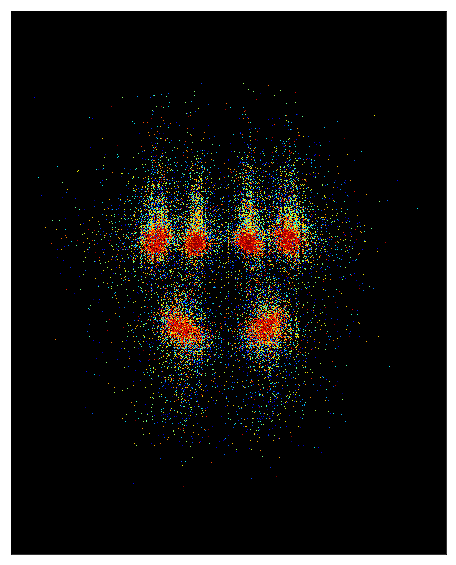

In [174]:
cv.imwrite('face_tracer.png', im)
plt.figure(figsize=(10,10))
plt.xticks([]), plt.yticks([])
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))

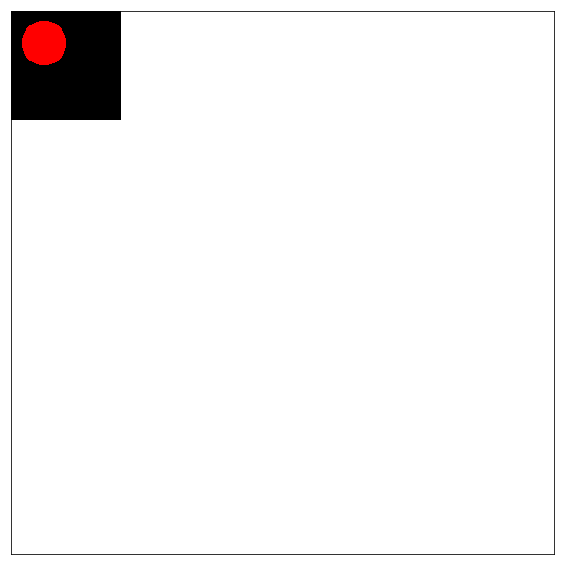

In [112]:
im = Image.new('RGB', (500,500), color='#FFFFFF')
im_draw = ImageDraw.Draw(im)
im_draw.rectangle(((0, 0), (100, 100)), fill="black")
im_draw.ellipse( (10, 10, 50, 50), fill="#ff0000")

plt.figure(figsize=(10,10))
plt.xticks([]), plt.yticks([])
plt.imshow(im)